In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [3]:
#uncomment this decorator to test your code
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x,y,theta = curr_pose 
    x = x + v*np.cos(theta)*dt
    y = y + v*np.sin(theta)*dt
    theta = theta + w*dt   
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x,y,theta


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [4]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps)
all_w= np.zeros(steps)
for v,w in zip(all_v,all_w):
   #instruction to take v, w and compute new pose 
   straight_trajectory.append(pose)
   pose = unicycle_model(pose,v,w)
straight_trajectory = np.array(straight_trajectory)

In [5]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps*100)
all_w = np.ones(steps*100)
for v,w in zip(all_v,all_w):
    #instruction to take v, w and compute new pose    
    circle_trajectory.append(pose)
    # store new pose
    pose = unicycle_model(pose,v,w,0.1)
circle_trajectory = np.array(circle_trajectory)

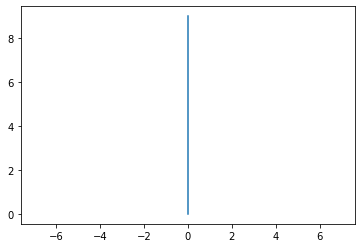

In [6]:
### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])


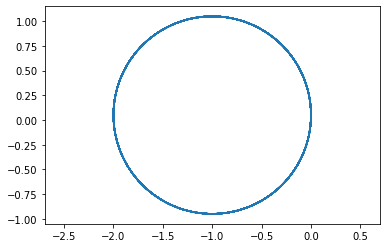

In [7]:
#circle trajectory
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1])

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [8]:
v_c = 1.0
w_c = np.pi/6

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2*w_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros
t_straight1, t_straight2, t_straight3 = int(10/v_c),int(5/v_c),int(8/v_c)
all_w = [0.0] * t_straight1 + [w_c]*t_turn + [0.0]*t_straight2 + [-w_c]*t_turn + [0.0]*t_straight3 + [w_c]*t_turn
all_v = v_c*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [9]:
def get_open_loop_commands(route, vc=1, wc=np.pi/12):
    all_w = []
    omegas = {'straight': 0, 'left': wc, 'right': -wc}
    for manoeuvre, command in route:
      t_cmd = int(np.ceil(command/vc)) if manoeuvre == 'straight' else int(np.ceil(np.deg2rad(command)/wc))
      all_w += [omegas[manoeuvre]]*int(t_cmd)
    all_v = vc*np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [10]:
all_v,all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [11]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w):
    #instruction to take v, w and compute new pose    
    robot_trajectory.append(pose)
    pose = unicycle_model(pose,v,w)
   # store new pose
robot_trajectory = np.array(robot_trajectory)

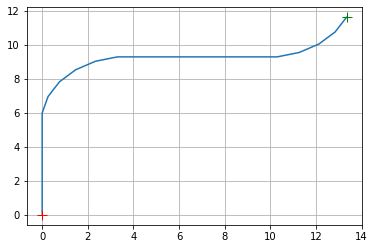

In [12]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'g+', ms=10)


### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)

###Two Velocities

In [13]:
##Velocity Slowed down version

def get_open_loop_commands_v2(route,vc_straight=1.0,vc_turn=np.pi/24,wc=np.pi/12):
    all_w_v2 = []
    all_v_v2 = []
    omegas = {'straight': 0, 'left': wc, 'right': -wc}
    velocities = {'straight':vc_straight , 'left': vc_turn, 'right': vc_turn}
    for manoeuvre, command in route:
      t_cmd = int(np.ceil(command/vc_straight)) if manoeuvre == 'straight' else int(np.ceil(np.deg2rad(command)/wc))
      all_w_v2 += [omegas[manoeuvre]]*int(t_cmd)
      all_v_v2 += [velocities[manoeuvre]]*int(t_cmd)
    return all_v_v2,all_w_v2

In [14]:
all_v_v2,all_w_v2 = get_open_loop_commands_v2([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [15]:
robot_trajectory_v2 = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v_v2, all_w_v2):
    #instruction to take v, w and compute new pose    
    robot_trajectory_v2.append(pose)
    pose = unicycle_model(pose,v,w)
   # store new pose
robot_trajectory_v2 = np.array(robot_trajectory_v2)

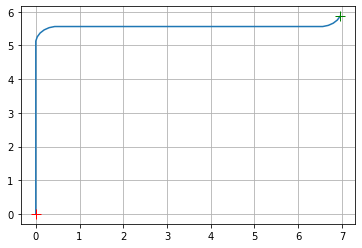

In [16]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory_v2[:,0],robot_trajectory_v2[:,1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory_v2[0]
xf, yf, _ = robot_trajectory_v2[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'g+', ms=10)


###Sampling Time

In [25]:
def get_open_loop_commands_v3(route,dt,vc_straight=1.0,vc_turn=np.pi/24,wc=np.pi/12):
    all_w_v3 = []
    all_v_v3 = []
    omegas = {'straight': 0, 'left': wc, 'right': -wc}
    velocities = {'straight':vc_straight , 'left': vc_turn, 'right': vc_turn}
    for manoeuvre, command in route:
      t_cmd = int(np.ceil(command/vc_straight*dt)) if manoeuvre == 'straight' else int(np.ceil(np.deg2rad(command)/wc*dt))
      all_w_v3 += [omegas[manoeuvre]]*int(t_cmd)
      all_v_v3 += [velocities[manoeuvre]]*int(t_cmd)
    return all_v_v3,all_w_v3

In [26]:
all_v_v3,all_w_v3 = get_open_loop_commands_v3([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],0.8)

In [29]:
robot_trajectory_v3 = []
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v_v3, all_w_v3):
    #instruction to take v, w and compute new pose    
    robot_trajectory_v3.append(pose)
    pose = unicycle_model(pose,v,w)
   # store new pose
robot_trajectory_v3 = np.array(robot_trajectory_v3)

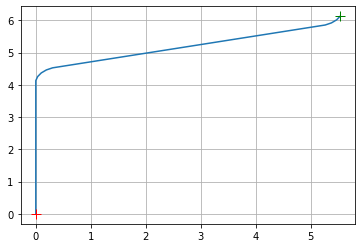

In [30]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory_v3[:,0],robot_trajectory_v3[:,1])

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory_v3[0]
xf, yf, _ = robot_trajectory_v3[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf, yf, 'g+', ms=10)
